# Stacking

Stacked generalization is an ensemble technique that involves two stages.
The first stage trains a set of $M$ models on $N$ observations and stores their predictions in a $L_{1} = N \times M$ data set.
The second stage uses the dataset of predictions to train an ensemble model, called a **generalizer**.
The generalizer is meant to learn the strengths and weaknesses of each model through their predictions, and built a more accurate model.

The goal of a stacked generalization algorithm is not to better understand the relationship between a set of covariates $X$ and a target variable $y$. 
The goal is to make as accurate a model as possible.

## Stages

We will use the Boston housing market dataset to understand stacking.
The goal will be to predict the median value of homes in Boston given several characteristics of the housing market.

In [1]:
require(mlbench)
data(BostonHousing)

dim(BostonHousing)
summary(BostonHousing)

Loading required package: mlbench



[1] 506  14

      crim                zn             indus       chas         nox        
 Min.   : 0.00632   Min.   :  0.00   Min.   : 0.46   0:471   Min.   :0.3850  
 1st Qu.: 0.08204   1st Qu.:  0.00   1st Qu.: 5.19   1: 35   1st Qu.:0.4490  
 Median : 0.25651   Median :  0.00   Median : 9.69           Median :0.5380  
 Mean   : 3.61352   Mean   : 11.36   Mean   :11.14           Mean   :0.5547  
 3rd Qu.: 3.67708   3rd Qu.: 12.50   3rd Qu.:18.10           3rd Qu.:0.6240  
 Max.   :88.97620   Max.   :100.00   Max.   :27.74           Max.   :0.8710  
       rm             age              dis              rad        
 Min.   :3.561   Min.   :  2.90   Min.   : 1.130   Min.   : 1.000  
 1st Qu.:5.886   1st Qu.: 45.02   1st Qu.: 2.100   1st Qu.: 4.000  
 Median :6.208   Median : 77.50   Median : 3.207   Median : 5.000  
 Mean   :6.285   Mean   : 68.57   Mean   : 3.795   Mean   : 9.549  
 3rd Qu.:6.623   3rd Qu.: 94.08   3rd Qu.: 5.188   3rd Qu.:24.000  
 Max.   :8.780   Max.   :100.00   Max.   :12.1

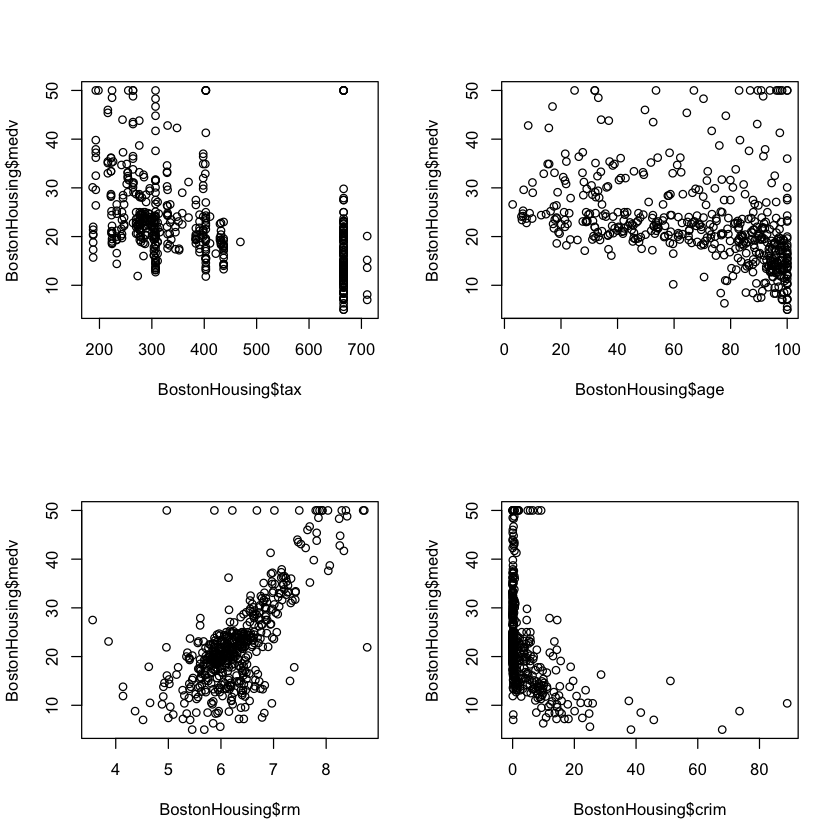

In [2]:
par(mfrow=c(2,2))
plot(BostonHousing$tax,BostonHousing$medv)
plot(BostonHousing$age,BostonHousing$medv)
plot(BostonHousing$rm,BostonHousing$medv)
plot(BostonHousing$crim,BostonHousing$medv)

## (1) Partition data into training and testing.
Stacking occurs in stages.
The first stage partitions your data into a training and test set.

In [3]:
percentTraining = 0.80
BostonHousing['train'] = runif(nrow(BostonHousing)) < percentTraining

training = BostonHousing[BostonHousing$train==1,]
testing  = BostonHousing[BostonHousing$train==0,]

print(head(BostonHousing,10))

print('size of training data')
dim(training)

print('size of testing data')
dim(testing)

      crim   zn indus chas   nox    rm   age    dis rad tax ptratio      b
1  0.00632 18.0  2.31    0 0.538 6.575  65.2 4.0900   1 296    15.3 396.90
2  0.02731  0.0  7.07    0 0.469 6.421  78.9 4.9671   2 242    17.8 396.90
3  0.02729  0.0  7.07    0 0.469 7.185  61.1 4.9671   2 242    17.8 392.83
4  0.03237  0.0  2.18    0 0.458 6.998  45.8 6.0622   3 222    18.7 394.63
5  0.06905  0.0  2.18    0 0.458 7.147  54.2 6.0622   3 222    18.7 396.90
6  0.02985  0.0  2.18    0 0.458 6.430  58.7 6.0622   3 222    18.7 394.12
7  0.08829 12.5  7.87    0 0.524 6.012  66.6 5.5605   5 311    15.2 395.60
8  0.14455 12.5  7.87    0 0.524 6.172  96.1 5.9505   5 311    15.2 396.90
9  0.21124 12.5  7.87    0 0.524 5.631 100.0 6.0821   5 311    15.2 386.63
10 0.17004 12.5  7.87    0 0.524 6.004  85.9 6.5921   5 311    15.2 386.71
   lstat medv train
1   4.98 24.0  TRUE
2   9.14 21.6  TRUE
3   4.03 34.7  TRUE
4   2.94 33.4  TRUE
5   5.33 36.2  TRUE
6   5.21 28.7  TRUE
7  12.43 22.9  TRUE
8  19.15 27.1  

[1] 410  15

[1] "size of testing data"


[1] 96 15

## (2) Cross validation for out-of-sample predictions

Next we split our training data into $K$ folds.
For every fold $k$, we train on the left over $K-1$ folds and make predictions on fold $k$. 
We repeat this process for all $M$ component models.

We will use a KNN neighbor regression, linear regression, polynomial regression, and regression tree to predict the median value of houses (medv).

In [4]:
require(FNN)   # for the KNN model
require(rpart) # for the TBR model

K = 10
training = training[,names(training)!='train']
trainingFolds = split(training,1:K)

dataSetOfPredictions = matrix()
for(k in 1:K){
    sprintf("Fold %d", k)
    
    outOfSample = trainingFolds[[k]]
    outOfSampleX = outOfSample[,names(outOfSample)!='medv']
    
    leftOver = setdiff(1:K,k)
    trainingSamples = do.call(rbind,trainingFolds[leftOver])
    
    trainY = trainingSamples[,names(trainingSamples)=='medv']
    trainX = trainingSamples[,names(trainingSamples)!='medv']
    
    # KNN model
    m1_predictions = knn.reg(train = as.matrix(trainingSamples$crim)
                 ,test = as.matrix(outOfSampleX$crim)
                 ,y=as.matrix(trainY),k=10)$pred
    
    #linear regression
    m2 = lm(medv~., data = trainingSamples)
    m2_predictions = predict(m2,outOfSampleX) 
    
    #polynomial regression
    m3 = lm(medv~tax + age + rm + crim + I(tax^2) + I(age^2) + I(rm^2) + I(crim^2), data = trainingSamples)
    m3_predictions = predict(m3,outOfSampleX) 
    
    #TBR
    m4 = rpart(medv ~ ., method="anova", data=trainingSamples)
    m4_predictions = predict(m4,outOfSampleX) 
    
    # build data set of out-of-sample predictions
    if (k==1){
        allDataSetOfPredictions = cbind(m1_predictions,m2_predictions,m3_predictions,m4_predictions,outOfSample$medv)
    } else {
        dataSetOfPredictions    = cbind(m1_predictions,m2_predictions,m3_predictions,m4_predictions,outOfSample$medv)
        allDataSetOfPredictions = rbind(allDataSetOfPredictions,dataSetOfPredictions,outOfSample$medv)
    }
}

Loading required package: FNN

Loading required package: rpart

Warning message in rbind(allDataSetOfPredictions, dataSetOfPredictions, outOfSample$medv):
“number of columns of result is not a multiple of vector length (arg 3)”
Warning message in rbind(allDataSetOfPredictions, dataSetOfPredictions, outOfSample$medv):
“number of columns of result is not a multiple of vector length (arg 3)”
Warning message in rbind(allDataSetOfPredictions, dataSetOfPredictions, outOfSample$medv):
“number of columns of result is not a multiple of vector length (arg 3)”
Warning message in rbind(allDataSetOfPredictions, dataSetOfPredictions, outOfSample$medv):
“number of columns of result is not a multiple of vector length (arg 3)”
Warning message in rbind(allDataSetOfPredictions, dataSetOfPredictions, outOfSample$medv):
“number of columns of result is not a multiple of vector length (arg 3)”
Warning message in rbind(allDataSetOfPredictions, dataSetOfPredictions, outOfSample$medv):
“number of columns of res

In [5]:
cbind(m1_predictions,m2_predictions,m3_predictions,m4_predictions,outOfSample$medv)

,m1_predictions,m2_predictions,m3_predictions,m4_predictions,
10,21.46,19.027995,20.009662,18.359615,18.9
22,20.87,17.810408,19.477677,20.613793,19.6
34,16.27,14.443087,18.148213,18.359615,13.1
47,21.18,20.583063,22.681509,20.613793,20.0
62,21.46,18.960698,19.837244,18.359615,16.0
75,27.02,25.537439,24.221358,22.750877,24.1
85,23.64,24.591988,24.919208,22.750877,23.9
99,27.32,33.994662,40.953380,38.985714,43.8
111,21.85,20.466214,21.705076,20.613793,21.7
123,23.23,21.456362,21.415900,18.359615,20.5


We now have a dataset that includes an out-of-sample for prediction, for all $4$ models and for all observation in our training set.

In [6]:
allDataSetOfPredictions = data.frame(allDataSetOfPredictions)
names(allDataSetOfPredictions) = c('m1','m2','m3','m4','y')
print(head(allDataSetOfPredictions))

       m1       m2       m3       m4    y
X1  32.47 30.30560 24.90512 23.60122 24.0
X11 20.21 18.50869 21.81050 16.97647 15.0
X23 18.72 15.52379 20.15813 16.97018 15.2
X36 24.24 24.12824 21.02700 23.60122 18.9
X48 20.78 17.68533 21.36763 16.97018 16.6
X63 21.35 24.29733 23.99810 23.60122 22.2


## (3) Build Aggregator

The next step trains a model that aggregates the $M$ models together by training on the data set of out-of-sample predictions.
We can consider a linear regression model as our aggregator.


In [7]:
agg = lm(y~m1+m2+m3+m4,data = data.frame(allDataSetOfPredictions))
print(summary(agg))


Call:
lm(formula = y ~ m1 + m2 + m3 + m4, data = data.frame(allDataSetOfPredictions))

Residuals:
     Min       1Q   Median       3Q      Max 
-25.1627  -2.2186  -0.3911   1.8806  28.4699 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.25579    0.94770  -1.325   0.1859    
m1          -0.04067    0.04703  -0.865   0.3877    
m2           0.48766    0.05554   8.780   <2e-16 ***
m3           0.14123    0.05736   2.462   0.0142 *  
m4           0.47185    0.05293   8.915   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.408 on 414 degrees of freedom
Multiple R-squared:  0.7628,	Adjusted R-squared:  0.7605 
F-statistic: 332.8 on 4 and 414 DF,  p-value: < 2.2e-16



These estimates are for our training set. 
We still need to make predictions on our held out test set.

## (4) make predictions on test set

### (4.1) Train Models on whole training set

In [8]:
    # KNN model
    m1_predictions = knn.reg(train = as.matrix(training$crim)
                            ,test = as.matrix(testing$crim)
                            ,y=as.matrix(training$medv),k=10)$pred
    
    #linear regression
    m2 = lm(medv~., data = training)
    m2_predictions = predict(m2,testing) 
    
    #polynomial regression
    m3 = lm(medv~tax + age + rm + crim + I(tax^2) + I(age^2) + I(rm^2) + I(crim^2), data = training)
    m3_predictions = predict(m3,testing) 
    
    #TBR
    m4 = rpart(medv ~ ., method="anova", data=training)
    m4_predictions = predict(m4,testing) 


testSetPredictions = cbind(m1_predictions,m2_predictions,m3_predictions,m4_predictions)
testSetPredictions = data.frame(testSetPredictions)
names(testSetPredictions) = c('m1','m2','m3','m4')

AggregatorModelPredictionsOnTestSet = predict(agg,data.frame(testSetPredictions))
print(AggregatorModelPredictionsOnTestSet)

       20        21        26        30        35        40        45        52 
19.425249 14.770881 15.017293 21.199896 15.189805 28.215449 23.499058 23.922685 
       53        56        58        60        64        71        73        87 
26.177563 32.121589 32.353396 22.429286 27.197722 25.004058 24.485570 21.572056 
       88        90        93       105       108       115       120       129 
24.582588 31.364341 26.688665 20.814034 20.544854 22.750873 20.511577 17.991880 
      130       131       137       141       159       160       161       163 
15.363997 20.353915 16.265534 12.211035 35.172640 33.866898 37.488204 43.554484 
      177       180       181       183       186       189       190       194 
23.059418 32.390298 40.853508 32.909490 22.865273 28.476424 33.447676 32.102800 
      201       206       211       218       225       233       234       240 
31.554960 22.049231 19.629651 24.650720 43.769164 43.453029 43.218009 26.517492 
      248       261       26

## (5) Compare your aggregated model to the test set

In [9]:
testSetAndAggPredictions = data.frame('T' = testing$medv
                                      ,'P' = AggregatorModelPredictionsOnTestSet
                                      ,'M1' = m1_predictions
                                      ,'M2' = m2_predictions
                                      ,'M3' = m3_predictions
                                      ,'M4' = m4_predictions)
SSE_AGG = sum( (testSetAndAggPredictions$T - testSetAndAggPredictions$P)^2 )

SSE_M1 = sum( (testSetAndAggPredictions$T - testSetAndAggPredictions$M1)^2 )
SSE_M2 = sum( (testSetAndAggPredictions$T - testSetAndAggPredictions$M2)^2 )
SSE_M3 = sum( (testSetAndAggPredictions$T - testSetAndAggPredictions$M3)^2 )
SSE_M4 = sum( (testSetAndAggPredictions$T - testSetAndAggPredictions$M4)^2 )


print(SSE_AGG)
print(SSE_M1)
print(SSE_M2)
print(SSE_M3)
print(SSE_M4)

[1] 1076.369
[1] 5304.312
[1] 1440.279
[1] 1380.285
[1] 2250.818


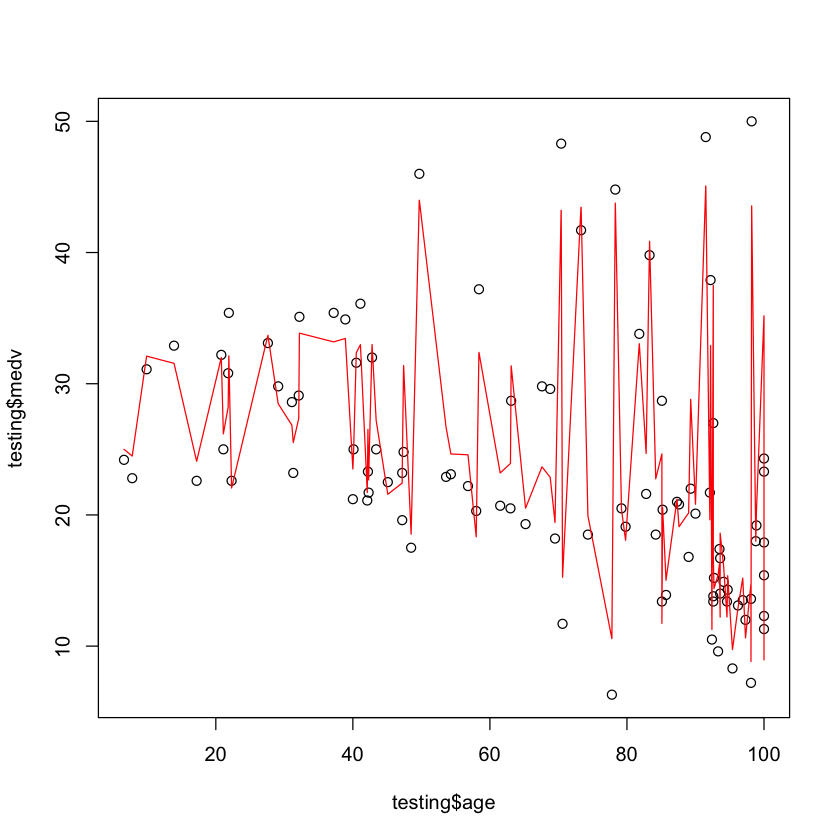

In [22]:
plot(testing$age, testing$medv)

S = order(testing$age)

lines(testing$age[S], testSetAndAggPredictions$P[S], col='red')